# Initiation aux système de recommandation

https://www.datacamp.com/community/tutorials/recommender-systems-python

# Simple Recommenders

La recommendation simple propose des recommandations généralisées en fonction de la popularité du film et parfois du genre.
L'idée de base derrière cette recommandation est que les films les plus populaires et les plus acclamés par la critique auront une probabilité plus élevée d'être appréciés par le public moyen. Ce modèle ne donne pas de recommandations personnalisées en fonction de l'utilisateur.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt

In [2]:
# Chargement du dataset  Movies Metadata
md = pd.read_csv('movies_metadata.csv', low_memory=False)

# Visualisation des trois premieres lignes du dataset
md.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [3]:
#ici on transforme la colonne genre qui est en format json en liste sans ponctuation json 
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


In [4]:
md.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0



L'étape suivante consiste à déterminer une valeur appropriée pour m, le nombre minimum de votes requis pour figurer dans le tableau. Nous utiliserons le 95e centile comme seuil. En d'autres termes, pour qu'un film figure dans les classements, il doit avoir plus de votes qu'au moins 95% des films de la liste.


In [5]:
# Calcul de la moyenne des votes sans les valeurs nulles
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [6]:
m = vote_counts.quantile(0.95)
m

434.0

In [7]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [8]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

Par conséquent,pour être dans le le classement, un film doit avoir au moins 434 votes. Nous constatons également que la note moyenne d'un film sur TMDB est de 5,244/10. 2274 films sont qualifiés pour figurer dans notre classement.

In [9]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [10]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [11]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

## Top Movies 

In [12]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


Nous voyons que trois films de Christopher Nolan, Inception, The Dark Knight et Interstellar se trouvent tout en haut de notre classement. Le graphique indique également un fort biais des utilisateurs vers des genres et des réalisateurs particuliers.

Construisons maintenant notre fonction qui construit des graphiques pour des genres particuliers. Pour cela, nous allons assouplir les conditions par défaut au 85e centile au lieu de 95.


In [13]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [14]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified


Affichons le top 5 des thrillers :

In [15]:
build_chart('Thriller').head(5)

,title,year,vote_count,vote_average,popularity,wr
15480,Inception,2010,14075,8,29.108149,7.956460
12481,The Dark Knight,2008,12269,8,123.167259,7.950165
292,Pulp Fiction,1994,8670,8,140.950236,7.929996
46,Se7en,1995,5915,8,18.45743,7.898573
24860,The Imitation Game,2014,5895,8,31.59594,7.898242


In [16]:
build_chart('Romance').head(5)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154


Le meilleur thriller selon mon classement est "Inception" alors que le meilleur film d'amour est "Dilwale Dulhania Le Jayenge"

# Demographic Filtering 

#### Metric for film evaluation

WeightedRating (WR) :
\begin{equation}
    \displaystyle WR = \Big( \frac{v}{v+m}.R \Big) + \Big( \frac{v}{v+m}.C \Big) 
\end{equation}

where :
* $v$ is the number of votes for the movie;
* $m$ is the minimum votes required to be listed in the chart;
* $R$ is the average rating of the movie;
* $C$ is the mean vote across the whole report.

In [17]:
# C = md['vote_average'].mean()
# print(C)
# Calcul de la moyenne des votes sans les valeurs nulles
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

Ainsi, la note moyenne pour tous les films est d'environ 5.2 sur une échelle de 10. 

L'étape suivante consiste à déterminer une valeur appropriée pour m, le nombre minimum de votes requis pour figurer dans le tableau. Nous utiliserons le 90e centile comme seuil. En d'autres termes, pour qu'un film figure dans les classements, il doit avoir plus de votes qu'au moins 90% des films de la liste.

In [18]:
# Calculate the minimum number of votes required to be in the chart, m
m = md['vote_count'].quantile(0.90)
print(m)

160.0


Maintenant, nous pouvons filtrer les films qui sont éligibles 

In [19]:
# Filter out all qualified movies into a new DataFrame
# On utilise la méthode .copy pour être sur que le nouveau dataset q_movies est independant des metadonnées du dataset original
q_movies = md.copy().loc[md['vote_count'] >= m]
q_movies.shape
print('La dimentsion du Dataset complet est : ', md.shape)

La dimentsion du Dataset complet est :  (45466, 25)


Nous voyons qu'il y a 4555 films qui se qualifient pour être dans cette liste sur 45466 films. Maintenant, nous devons calculer notre métrique pour chaque film qualifié. Pour ce faire, nous allons définir une fonction *weighted_rating ()* et définir un nouveau score de fonctionnalité, dont nous calculerons la valeur en appliquant cette fonction à notre Dataset contenant les  films qualifiés:

In [20]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formule
    return (v/(v+m) * R) + (m/(m+v) * C)

In [21]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

Enfin, trions le DataSet en fonction du titre, le nombre de votes, la moyenne des votes et la note pondérée ou le score des 10 meilleurs films.

In [22]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 10 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.438857
834,The Godfather,6024.0,8.5,8.415780
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.348701
12481,The Dark Knight,12269.0,8.3,8.260671
2843,Fight Club,9678.0,8.3,8.250313
292,Pulp Fiction,8670.0,8.3,8.244641
522,Schindler's List,4436.0,8.3,8.193643
23673,Whiplash,4376.0,8.3,8.192236
5481,Spirited Away,3968.0,8.3,8.181585
2211,Life Is Beautiful,3643.0,8.3,8.171466


Text(0.5, 1.0, 'Popular Movies')

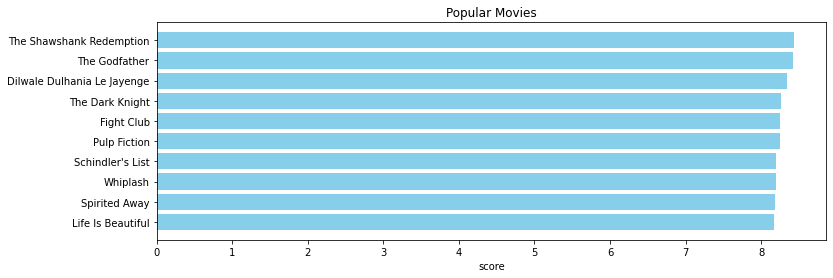

In [23]:
q_movies = q_movies.sort_values('score', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(q_movies['title'].head(10),q_movies['score'].head(10), align='center',color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("score")
plt.title("Popular Movies")


# Content-Based Recommender

Dans ce système de recommandation, le contenu du film (aperçu, distribution, équipe, mot-clé, slogan, etc.) est utilisé pour trouver sa similitude avec d'autres films. Ensuite, les films les plus susceptibles d'être similaires sont recommandés.
![](https://image.ibb.co/f6mDXU/conten.png)

In [24]:
#Print plot overviews of the first 5 movies.
md['overview'].head(5)

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

#### Calcul des vecteurs TF-IDF 

Nous allons calculer la fréquence des mots dans les overview c'est à dire la fréquence relative de chaque mot dans un document 

In [25]:
import pandas as pd
# Chargement du dataset  Movies Metadata
md = pd.read_csv('movies_metadata.csv', low_memory=False)
# md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


# Visualisation des trois premieres lignes deu dataset
md.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


Pour calculer la similarité cosinus, nous avez besoin du nombre de mots des mots de chaque document. Le CountVectorizer ou le TfidfVectorizerfrom scikit learn nous permet de calculer cela. La sortie de ceci est un fichier sparse_matrix.

In [26]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
md['overview'] = md['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(md['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape
print("La dimension de la matrice est  :",tfidf_matrix.shape)

La dimension de la matrice est  : (45466, 75827)


In [27]:
#Array mapping from feature integer indices to feature name.
ex = tfidf.get_feature_names()[5000:5010]
print("Voici quelques exemples de mot ici du corpus:", ex)

Voici quelques exemples de mot ici du corpus: ['avails', 'avaks', 'avalanche', 'avalanches', 'avallone', 'avalon', 'avant', 'avanthika', 'avanti', 'avaracious']


On peut voir qu'on utilise 75827 mots pour décrire 45466 mots.
Avec cette matrice en main, nous pouvons maintenant calculer un score de similarité. Il y a plusieurs méthodes pour cela; comme les scores euclidien, de Pearson et de similarité cosinus.
Nous allons expérimenter différentes métriques.

Nous utiliserons la similarité cosinus pour calculer une quantité numérique qui dénote la similitude entre deux films. Nous utilisons le score de similarité cosinus car il est indépendant de la magnitude et est relativement facile et rapide à calculer. 

Nous n'utiliserons pas *linear_kernel* () de sklearn (même si il est plus rapide, demande beaucoup de mémoire et fait planter le noyau).Nous utiliserons plus tôt plus lent mais utilise moins de mémoire*cosine_similarity* . 
*cosine_similarity* permet de calculer une quantité numérique qui dénote la similitude entre deux films.

Cependant vous trouverez ci-joint le code commentée du calcul de similarité avec *linear_kernel* () de sklearn 


In [28]:
# # Import linear_kernel
# from sklearn.metrics.pairwise import linear_kernel

# # Compute the cosine similarity matrix
# cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print("IMPOSSIBLE de calculer la matrice de cosinus similarity de cette manière -> EXPLOSE EN MEMOIRE")

IMPOSSIBLE de calculer la matrice de cosinus similarity de cette manière -> EXPLOSE EN MEMOIRE


Nous allons définir une fonction qui prend un titre de film comme entrée et génère une liste des 10 films les plus similaires. Tout d'abord, pour cela, nous avons besoin d'un mapping inversé des titres de films et des indices DataFrame. En d'autres termes, nous avons besoin d'un mécanisme pour identifier l'index d'un film dans nos métadonnées Dataset, compte tenu de son titre.

In [29]:
# cosine_sim.shape

In [30]:
# cosine_sim[1]

In [31]:
# #Construct a reverse map of indices and movie titles
# indices = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()

In [32]:
# indices[:10]

In [33]:
# # Function that takes in movie title as input and outputs most similar movies
# def get_recommendations(title):
#     # Get the index of the movie that matches the title
#     idx = indices[title]

#     # Get the pairwsie similarity scores of all movies with that movie
#     sim_scores = list(enumerate(cosine_sim[idx]))

#     # Sort the movies based on the similarity scores
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

#     # Get the scores of the 10 most similar movies
#     sim_scores = sim_scores[1:11]

#     # Get the movie indices
#     movie_indices = [i[0] for i in sim_scores]

#     # Return the top 10 most similar movies
#     return md['title'].iloc[movie_indices]

In [34]:
# get_recommendations('The Dark Knight Rises')

In [35]:
# get_recommendations('The Godfather')

# cosine_similarity()

La similarité cosinus (ou mesure cosinus) permet de calculer la similarité entre deux vecteurs à n dimensions en déterminant le cosinus de l'angle entre eux. Cette métrique est fréquemment utilisée en fouille de textes1.

Soit deux vecteurs A et B, l'angle θ s'obtient par le produit scalaire et la norme des vecteurs :

#### Exemple : Cosinus similarity

\begin{equation}
    \displaystyle \cos(x, y) = \frac{x.y^T}{||x||.||y||} = \frac{\sum_{i=1}^n x_i.y_i^{T}}{\sqrt{\sum_{i=1}^n (x_i)^2}\sqrt{\sum_{i=1}^n (y_i)^2}}
\end{equation}


Comme la valeur cos θ est comprise dans l'intervalle [-1,1], la valeur -1 indiquera des vecteurs résolument opposés, 0 des vecteurs indépendants (orthogonaux) et 1 des vecteurs similaires (colinéaires de coefficient positif). Les valeurs intermédiaires permettent d'évaluer le degré de similarité.

In [36]:
en_ligne = False
dense_output_choice = False# True or False

In [37]:
if en_ligne==True:
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix, dense_output=dense_output_choice)


En l'executant sur google collab je trouve que la matrice de 45466*45466 élément (soit 2067157156 éléments) devrait prendre en mémoire 16537257248 octets (16,5 Go)

In [38]:
if en_ligne==True:
    print(cosine_sim[1,:5])

In [39]:
if en_ligne==True:
    cosine_sim[1,:].toarray()

In [40]:
#  Construct a reverse map of indices and movie titles
indices = pd.Series(md.index, index=md['title']).drop_duplicates()

In [41]:
indices[:10]

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
Heat                           5
Sabrina                        6
Tom and Huck                   7
Sudden Death                   8
GoldenEye                      9
dtype: int64

In [42]:
# if en_ligne==True:
#     # Function that takes in movie title as input and outputs most similar movies
#     def get_recommendations(title, cosine_sim=cosine_sim):
#         # Get the index of the movie that matches the title
#         idx = indices[title]

#         # Get the pairwsie similarity scores of all movies with that movie
#         sim_scores = list(enumerate(cosine_sim[:,idx].toarray()))

#         # Sort the movies based on the similarity scores
#         sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

#         # Get the scores of the 10 most similar movies
#         sim_scores = sim_scores[1:11]

#         # Get the movie indices
#         movie_indices = [i[0] for i in sim_scores]

#         # Return the top 10 most similar movies
#         return md['title'].iloc[movie_indices]
    # Function that takes in movie title as input and outputs most similar movies


# Fonction de recommandation

In [43]:
if en_ligne==True:# Function that takes in movie title as input and outputs most similar movies
    def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
        idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
        sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
        sim_scores = sim_scores[1:11]

    # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
        return md['title'].iloc[movie_indices]

In [44]:
if en_ligne==True:
    get_recommendations('The Dark Knight Rises')

In [45]:
if en_ligne==True:
    get_recommendations('The Godfather')

##  Calcul de cosine similarity pour un film donné 

In [46]:
title = 'The Dark Knight Rises'
import time
t0 = time.time()
cosine_sim_1titre = cosine_similarity(tfidf_matrix[indices[title],:], tfidf_matrix, dense_output=dense_output_choice)
tps = time.time() - t0
print('temps execution', tps, 'secondes')

temps execution 0.07810759544372559 secondes


In [47]:
# Function that takes in movie title as input and outputs most similar movies
def get_reco_calcul_live(title, X=tfidf_matrix, nb_films=10):
    # Get the index of the movie that matches the title
    idx = indices[title]
    
    if X.shape == tfidf_matrix.shape:
        ## Compute the cosine similarity vector according to the current Film
        cosine_sim_1titre = cosine_similarity(X[idx,:], X)
    else:
        cosine_sim_1titre = cosine_similarity(X[idx,:].reshape(1, -1), X)

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim_1titre[0]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the n most similar movies
    sim_scores = sim_scores[1:nb_films+1]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return md.iloc[movie_indices]

In [48]:
Film = 'The Dark Knight Rises'
t0 = time.time()
list_reco = get_reco_calcul_live(Film)
tps = time.time() - t0
print('temps execution', tps, 'secondes')
print('Liste de recommandation pour le Film {} : {}'.format(Film, list_reco['title']))

temps execution 0.10942220687866211 secondes
Liste de recommandation pour le Film The Dark Knight Rises : 12481                                      The Dark Knight
150                                         Batman Forever
1328                                        Batman Returns
15511                           Batman: Under the Red Hood
585                                                 Batman
21194    Batman Unmasked: The Psychology of the Dark Kn...
9230                    Batman Beyond: Return of the Joker
18035                                     Batman: Year One
19792              Batman: The Dark Knight Returns, Part 1
3095                          Batman: Mask of the Phantasm
Name: title, dtype: object


In [49]:
Film = 'The Godfather'
t0 = time.time()
list_reco = get_reco_calcul_live(Film)
tps = time.time() - t0
print('temps execution', tps, 'secondes')
print('Liste de recommandation pour le Film {} : {}'.format(Film, list_reco['title']))

temps execution 0.12035036087036133 secondes
Liste de recommandation pour le Film The Godfather : 1178               The Godfather: Part II
44030    The Godfather Trilogy: 1972-1990
1914              The Godfather: Part III
23126                          Blood Ties
11297                    Household Saints
34717                   Start Liquidation
10821                            Election
38030            A Mother Should Be Loved
17729                   Short Sharp Shock
26293                  Beck 28 - Familjen
Name: title, dtype: object


Bien que notre système ait fait un travail décent pour trouver des films avec des descriptions d'intrigue similaires, la qualité des recommandations n'est pas terrible. "The Dark Knight Rises" renvoie tous les films de Batman alors qu'il est plus probable que les personnes qui ont aimé ce film soient plus enclines à apprécier d'autres films de Christopher Nolan. C'est quelque chose qui ne peut pas être saisi par le système actuel.

## Réduction de la dimension du corpus (using PCA / SVD)

In [50]:
def SVD_scaling(n_comp_svd):
    if n_comp_svd>3000:
        n_comp_svd =3000
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=n_comp_svd, random_state=42)
    svd.fit(tfidf_matrix)
    print('Cumulative explained variance ratio :', svd.explained_variance_ratio_.sum())
    return svd


n_comp_svd = 2000
svd = SVD_scaling(n_comp_svd)

Cumulative explained variance ratio : 0.442466133431352


In [51]:
X_trunc = svd.transform(tfidf_matrix)

In [52]:
Film = 'The Dark Knight Rises'
t0 = time.time()
list_reco = get_reco_calcul_live(Film, X_trunc)
tps = time.time() - t0
print('temps execution', tps, 'secondes')
print('Liste de recommandation pour le Film {} : {}'.format(Film, list_reco['title']))

temps execution 0.8638901710510254 secondes
Liste de recommandation pour le Film The Dark Knight Rises : 150                                         Batman Forever
12481                                      The Dark Knight
585                                                 Batman
15511                           Batman: Under the Red Hood
1328                                        Batman Returns
21194    Batman Unmasked: The Psychology of the Dark Kn...
25267                                    Batman vs Dracula
35983                                    Batman: Bad Blood
19792              Batman: The Dark Knight Returns, Part 1
18035                                     Batman: Year One
Name: title, dtype: object
